In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import skew,kurtosis
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from sklearn.linear_model import LinearRegression
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'sample_submission.csv', 'train.csv']


In [2]:
from scipy.stats import kurtosis
a=np.array([1,5,8,6,4,2])
kurtosis(a)

-1.1543999999999992

In [3]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error

In [4]:
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [5]:
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


In [6]:
# pandas doesn't show us all the decimals
pd.options.display.precision = 15

In [7]:
# much better!
train.head()
#train.shape

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


In [8]:
# Create a training file with simple derived features
from scipy.stats import kurtosis,skew
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
         columns=['ave', 'std', 'max', 'min','kurt','skew','25per','50per','75per'])
#X_train=pd.DataFrame(columns=['ave','std','max','min'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])
#y_train=pd.DataFrame(columns=['time_to_failure'])
for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    #print(seg['acoustic_data'].values)
    #print(seg['time_to_failure'].values[-1])
    y_train.loc[segment, 'time_to_failure'] = y
    
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()
    #X_train.loc[segment, 'mad'] = x.mad()
    X_train.loc[segment, 'kurt'] = kurtosis(x)
    X_train.loc[segment, 'skew'] = skew(x)
    X_train.loc[segment, '25per'] = np.quantile(x,0.25)
    X_train.loc[segment, '50per'] = np.quantile(x,0.50)
    X_train.loc[segment, '75per'] = np.quantile(x,0.75)

100%|██████████| 4194/4194 [00:53<00:00, 77.88it/s]


In [9]:
print(X_train.head())
print(y_train.head())
print(X_train.shape[0],y_train.shape[0])

                 ave                std    max  ...    25per  50per  75per
0  4.884113333333334  5.101089126891323  104.0  ...      3.0    5.0    7.0
1  4.725766666666667  6.588801819164257  181.0  ...      2.0    5.0    7.0
2  4.906393333333333  6.967373808828945  140.0  ...      2.0    5.0    7.0
3  4.902240000000000  6.922282112791032  197.0  ...      2.0    5.0    7.0
4  4.908720000000000  7.301085852684289  145.0  ...      2.0    5.0    7.0

[5 rows x 9 columns]
   time_to_failure
0     1.4307971859
1     1.3914988931
2     1.3531960947
3     1.3137978019
4     1.2743995091
4194 4194


In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
print(X_train_scaled)

[[ 1.4241405  -0.17021358 -0.21819351 ...  1.59431559  0.94703708
   0.28882204]
 [ 0.80571603  0.00473402  0.06393601 ... -0.4058518   0.94703708
   0.28882204]
 [ 1.51115526  0.0492522  -0.0862888  ... -0.4058518   0.94703708
   0.28882204]
 ...
 [ 0.34265275 -0.39124963 -0.36841832 ...  1.59431559  0.94703708
   0.28882204]
 [-0.21161721 -0.28084016 -0.25483371 ... -0.4058518  -1.05592486
  -1.81051872]
 [-0.00415653 -0.37312925 -0.3647543  ...  1.59431559  0.94703708
  -1.81051872]]


In [11]:
svm = NuSVR()
svm.fit(X_train_scaled, y_train.values.flatten())
y_pred = svm.predict(X_train_scaled)

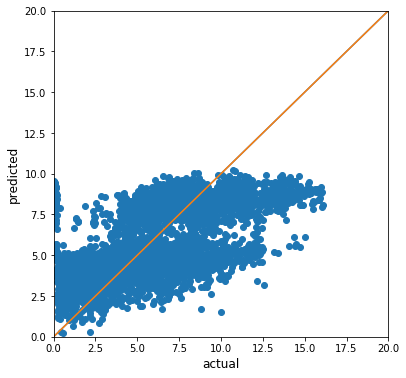

In [12]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train.values.flatten(), y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [13]:
score = mean_absolute_error(y_train.values.flatten(), y_pred)
print(f'Score: {score:0.3f}')

Score: 2.216


In [14]:
linearRegressor = LinearRegression()
linearRegressor.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = linearRegressor.predict(X_train_scaled)


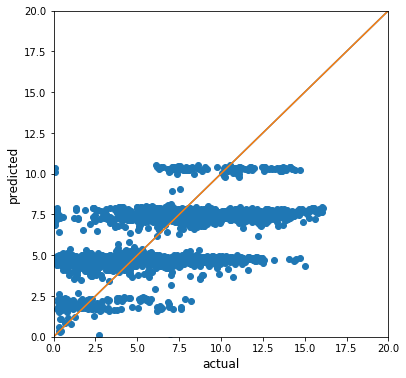

In [15]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train.values.flatten(), y_pred1)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [16]:
score = mean_absolute_error(y_train.values.flatten(), y_pred1)
print(f'Score: {score:0.3f}')

Score: 2.516


In [17]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')

In [18]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)


In [19]:
print(X_test.index)
for seg_id in X_test.index:
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    print(seg_id)
    print(x.mean())
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
    X_test.loc[seg_id, 'kurt'] = kurtosis(x)
    X_test.loc[seg_id, 'skew'] = skew(x)
    X_test.loc[seg_id, '25per'] = np.quantile(x,0.25)
    X_test.loc[seg_id, '50per'] = np.quantile(x,0.50)
    X_test.loc[seg_id, '75per'] = np.quantile(x,0.75)

Index(['seg_00030f', 'seg_0012b5', 'seg_00184e', 'seg_003339', 'seg_0042cc',
       'seg_004314', 'seg_004cd2', 'seg_004ee5', 'seg_004f1f', 'seg_00648a',
       ...
       'seg_feb312', 'seg_fedbd1', 'seg_ff0f1b', 'seg_ff1a62', 'seg_ff2f2d',
       'seg_ff4236', 'seg_ff7478', 'seg_ff79d9', 'seg_ffbd6a', 'seg_ffe7cc'],
      dtype='object', name='seg_id', length=2624)
seg_00030f
4.49178
seg_0012b5
4.171153333333334
seg_00184e
4.61026
seg_003339
4.5314733333333335
seg_0042cc
4.12834
seg_004314
4.148606666666667
seg_004cd2
4.1139866666666665
seg_004ee5
4.32838
seg_004f1f
4.000733333333334
seg_00648a
4.4588
seg_006e4a
4.393326666666667
seg_007a37
4.00766
seg_00a37e
3.861213333333333
seg_00be11
4.156526666666666
seg_00c35b
4.52948
seg_00cc91
3.8979666666666666
seg_00e5f7
4.0284466666666665
seg_00f3b9
3.7068733333333332
seg_010eab
4.23326
seg_0125d9
4.286473333333333
seg_0144cb
4.14336
seg_0165c6
4.10442
seg_016913
3.87486
seg_016cdb
3.8884066666666666
seg_017314
4.175713333333333
seg_01a8dc

In [20]:
X_test

,ave,std,max,min,kurt,skew,25per,50per,75per
seg_id,,,,,,,,,
seg_00030f,4.491780000000000,4.893673374701939,115.0,-75.0,28.836566856132873,0.327904356179061,2.0,4.0,7.0
seg_0012b5,4.171153333333334,5.922819700375451,152.0,-140.0,56.217040603098553,0.295704902067299,2.0,4.0,7.0
seg_00184e,4.610260000000000,6.946966920827151,248.0,-193.0,162.112839736317284,0.428684001399945,2.0,5.0,7.0
seg_003339,4.531473333333333,4.114132889113924,85.0,-93.0,41.240412747645323,0.061888744016031,3.0,5.0,7.0
seg_0042cc,4.128340000000000,5.797144312308719,177.0,-147.0,79.537016314536231,0.073897611771741,2.0,4.0,6.0
seg_004314,4.148606666666667,24.782686215554246,671.0,-675.0,159.646280564853583,1.016350811927968,0.0,4.0,8.0
seg_004cd2,4.113986666666666,4.707134341240846,125.0,-107.0,57.042099067471270,0.081860639165991,2.0,4.0,6.0
seg_004ee5,4.328380000000000,5.964423406801365,120.0,-120.0,35.503066717721282,0.161539554597780,2.0,4.0,7.0
seg_004f1f,4.000733333333334,5.874449715694418,118.0,-114.0,37.258953005433696,-0.007194801260897,2.0,4.0,6.0


In [21]:
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = svm.predict(X_test_scaled)
submission.to_csv('submission.csv')
print("Done")

Done
